# imports

In [1]:
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# impute.imputer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA
# stats : R module
from scipy.stats import skew, kurtosis

# estimators ---------------------------------------
# estimators.classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV # regressor 응용
# estimators.regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
# --------------------------------------------------

# neural network -----------------------------------
import tensorflow as tf
import keras
# --------------------------------------------------

# ensemble -----------------------------------------
# ensemble.bagging
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# ensemble.boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
# ensemble.boosting & bagging
from xgboost import XGBRFClassifier, XGBRFRegressor
# ensemble.voting
from sklearn.ensemble import VotingClassifier, VotingRegressor
# --------------------------------------------------

# metrics ------------------------------------------
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# --------------------------------------------------

# model_selection ----------------------------------
# model_selection.splitter
from sklearn.model_selection import train_test_split
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV
# --------------------------------------------------

# optuna -------------------------------------------
import optuna
# --------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm

from IPython.core.display import display, HTML
# display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

plt.rcParams['font.family'] = 'Malgun Gothic'

# read

In [3]:
cus   = pd.read_csv('./data/cus_info.csv')
iem   = pd.read_csv('./data/iem_info_20210902.csv')
hist  = pd.read_csv('./data/stk_bnc_hist.csv')
train = pd.read_csv('./data/stk_hld_train.csv')
test  = pd.read_csv('./data/stk_hld_test.csv')
sub   = pd.read_csv('./data/sample_submission.csv')

# EDA

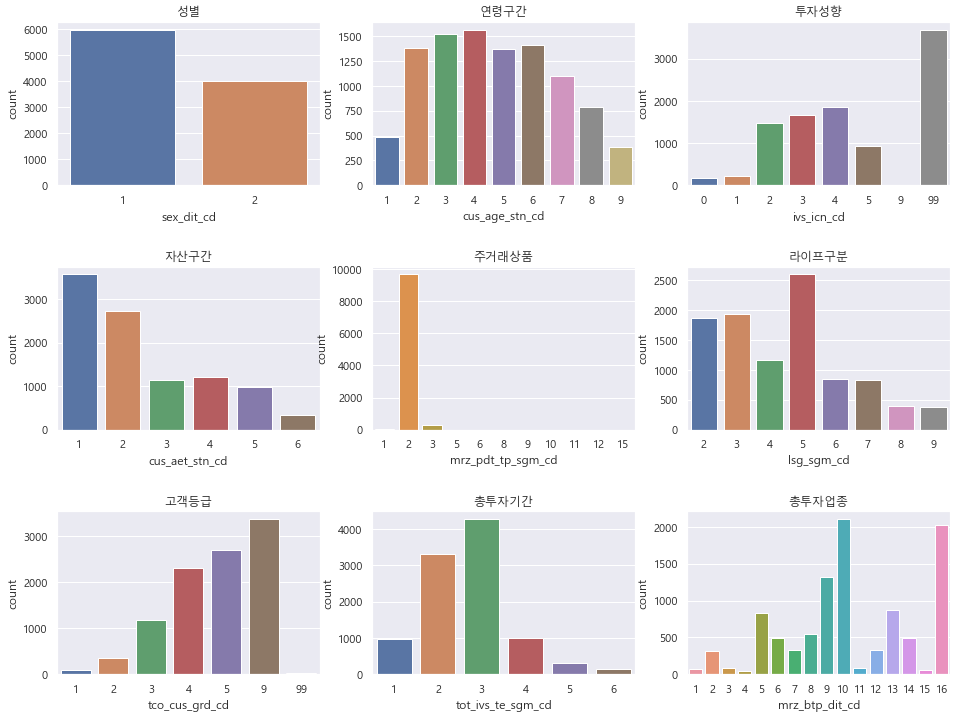

In [4]:
cus_cols = ['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd']
cols     = ['성별', '연령구간', '투자성향', '자산구간', '주거래상품', '라이프구분', '고객등급', '총투자기간', '총투자업종']    

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols):
    r = i // 3
    c = i % 3
    sns.countplot(col, data=cus, ax=ax[r, c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

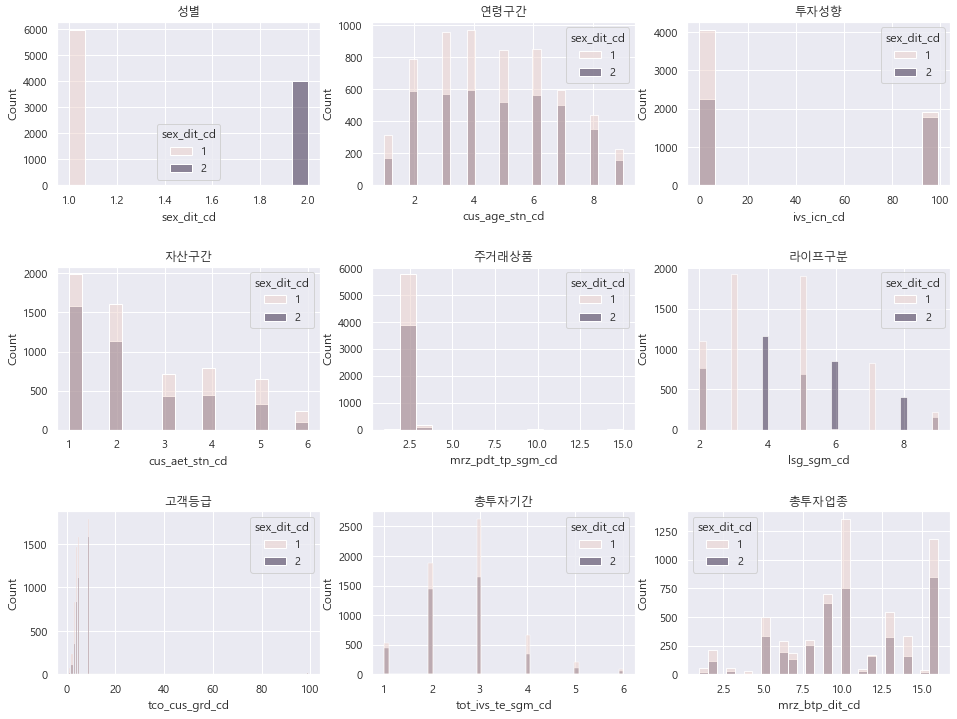

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols) :
    r = i // 3
    c = i % 3
    sns.histplot(data=cus, x=col, hue='sex_dit_cd', ax=ax[r ,c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# feature engineering

## cus.ivs_icn_cd : 투자성향

In [6]:
# 투자성향 미정의(99) 비율 0.3687 : drop
print(cus[cus['ivs_icn_cd'] == 99].shape[0] / cus.shape[0])
cus.drop('ivs_icn_cd', axis=1, inplace=True)

0.3687


## cus.lsg_sgm_cd : life stage

In [7]:
# 연령과 성별 변수 포함 : drop
cus.drop('lsg_sgm_cd', axis=1, inplace=True)

## cus.tco_cus_grd_cd : 고객등급

In [8]:
# 서비스 등급 결측치(99)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 1)] = 3 # 1억 이상, 3억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 2)] = 3 # 1억 이상, 3억 미만

# 서비스 등급 미정의(9)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 1)] = 9 # 1천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 2)] = 5 # 1천 이상, 3천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 3)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 4)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 5)] = 3 # 1억 이상, 3억 미만

# 이외의 서비스 등급 미정의(9)는 고객등급 6으로 설정
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9)] = 6

<AxesSubplot:>

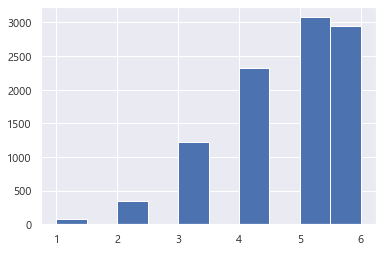

In [9]:
cus['tco_cus_grd_cd'].hist()

## iem.mkt_pr_tal_scl_tp_cd : 시총규모

In [10]:
# 기타(99) -> 3
iem['mkt_pr_tal_scl_tp_cd'][iem['mkt_pr_tal_scl_tp_cd'] == 99] = 3

## iem.stk_dit_cd : 시장구분

In [11]:
# 기타(99) -> 3
iem['stk_dit_cd'][iem['stk_dit_cd'] == 99] = 3

## hist.stk_p : 매매 평균단가

In [12]:
hist['stk_p'] = hist['tot_aet_amt'] / hist['bnc_qty']
hist['stk_p'].fillna(0, inplace=True)

## train.hist_d

In [13]:
gb_iem = train.groupby('iem_cd').min()[['hold_d']]
gb_iem.rename(columns={'hold_d':'hist_d'}, inplace=True)
gb_iem

,hist_d
iem_cd,
A000020,1
A000030,1
A000040,1
A000050,1
A000060,1
...,...
A371160,4
A371460,9
A371470,1


In [14]:
train = pd.merge(train, gb_iem, how='left', on='iem_cd')

In [15]:
train

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A006360,20180726,11,1
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A005930,20180131,80,1
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A005070,20180517,5,1
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A003520,20201112,22,1
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A002310,20180905,324,1
...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A260660,20180831,1,1
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A271980,20201027,1,1
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A289080,20181121,1,1
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A307930,20200214,1,1


# merge

## cus & iem

In [17]:
train_data = pd.merge(train, cus, how='left', on='act_id')
train_data = pd.merge(train_data, iem, how='left', on='iem_cd')

test_data = pd.merge(test, cus, how='left', on='act_id')
test_data = pd.merge(test_data, iem, how='left', on='iem_cd')

## hist

In [18]:
train_data = pd.merge(train_data, hist, how='left', on=['act_id', 'iem_cd'])
train_data = train_data[(train_data['byn_dt'] == train_data['bse_dt'])]

test_data = pd.merge(test_data, hist, how = 'left', on=['act_id', 'iem_cd'])
test_data = test_data[(test_data['byn_dt'] == test_data['bse_dt'])]

In [19]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# encode

In [20]:
le = LabelEncoder()
le.fit(iem['iem_krl_nm'])
train_data['iem_krl_nm'] = le.transform(train_data['iem_krl_nm'])
test_data['iem_krl_nm']  = le.transform(test_data['iem_krl_nm'])

# drop

In [21]:
train_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt'], axis=1, inplace=True)
test_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'submit_id', 'hold_d'], axis=1, inplace=True)

In [22]:
train_data.shape, test_data.shape

((681472, 17), (70596, 16))

# scale

In [23]:
rbs = RobustScaler()

rbs.fit(train_data[test_data.columns])
train_data[test_data.columns] = rbs.transform(train_data[test_data.columns])
test_data[test_data.columns]  = rbs.transform(test_data[test_data.columns])

In [24]:
train_data['hold_d'] = np.log1p(train_data['hold_d'])

# score

In [25]:
X_train_data = train_data.drop('hold_d', axis=1)
y_train_data = train_data['hold_d']

In [28]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(X_train_data):
    
    train_x = X_train_data.iloc[train_idx, :]
    train_y = y_train_data[train_idx]
    val_x = X_train_data.iloc[val_idx, :]
    val_y = y_train_data[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31,
                          random_state=0)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(model)

Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 1.29677	valid_0's l2: 1.6816
Early stopping, best iteration is:
[573]	valid_0's rmse: 1.29662	valid_0's l2: 1.68123
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 1.33315	valid_0's l2: 1.77728
[1000]	valid_0's rmse: 1.3294	valid_0's l2: 1.7673
[1500]	valid_0's rmse: 1.32835	valid_0's l2: 1.76451
[2000]	valid_0's rmse: 1.32806	valid_0's l2: 1.76376
Did not meet early stopping. Best iteration is:
[1988]	valid_0's rmse: 1.32804	valid_0's l2: 1.76368
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 1.34074	valid_0's l2: 1.79757
[1000]	valid_0's rmse: 1.34015	valid_0's l2: 1.79601
Early stopping, best iteration is:
[700]	valid_0's rmse: 1.33954	valid_0's l2: 1.79437
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 1.29508	valid_0's l2: 1.67724
[1000]	valid_0's rmse: 1.29282	valid_0's l2: 1.67137
[1500]	

In [29]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis=0)

In [30]:
sub['hold_d'] = np.expm1(predict)
sub

,submit_id,hold_d
0,IDX00001,17.863730
1,IDX00002,49.421173
2,IDX00003,42.726673
3,IDX00004,44.338080
4,IDX00005,12.768939
...,...,...
70591,IDX70592,40.197247
70592,IDX70593,55.877355
70593,IDX70594,64.140011
70594,IDX70595,11.382287


# label check

In [31]:
temp = pd.merge(test.drop('hold_d', axis=1), sub, how='left', on='submit_id')

over_cond = temp['hist_d'] >= temp['hold_d']            # hist_d >= hold_d
under_cond = ((temp['hold_d'] - temp['hist_d']) > 146)  # (hold_d - hist_d) > 146

temp[over_cond | under_cond]

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A032640,20200522,153,IDX00001,17.863730
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A160600,20190823,335,IDX00002,49.421173
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A234340,20200611,139,IDX00003,42.726673
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A131760,20200120,236,IDX00004,44.338080
5,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,A050110,20200814,93,IDX00006,72.044046
...,...,...,...,...,...,...
70587,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A033780,20191105,287,IDX70588,44.545871
70588,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A017670,20190723,357,IDX70589,111.044332
70590,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A005180,20200929,62,IDX70591,39.286894
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A005945,20200731,103,IDX70593,55.877355


In [ ]:
break

## (hold_d - hist_d) > 146 == hist_d + 146

In [ ]:
over_idx = temp[over_cond].index.tolist()
len(over_idx)

In [ ]:
sub.loc[over_idx, 'hold_d'] = temp.loc[over_idx, 'hist_d'] + 146

In [ ]:
sub

## hist_d < hold_d : hist_d + 1

In [ ]:
under_idx = temp[under_cond].index.tolist()
len(under_idx)

In [ ]:
sub.loc[under_idx, 'hold_d'] = temp.loc[under_idx, 'hist_d'] + 1

In [ ]:
sub

# to_csv

In [ ]:
# sub.to_csv('./sub/sub_pjh_07.csv', index=False)